In [77]:
%pylab inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils

from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

# from tqdm import trange, tqdm
from functools import partial
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)
trange = partial(trange, position=0, leave=True)


figsize(10,10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Sat Jun 25 17:41:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
DEVICE='cuda:0'

In [5]:
BATCH=256

In [6]:
train_data = datasets.MNIST(
	root='data',
	train=True,
	transform=transforms.Compose([
		ToTensor(),
		transforms.Normalize((0.5), (0.5))
	]),
	download=True,
);

trainloader = torch.utils.data.DataLoader(
	train_data,
	batch_size=BATCH,
	num_workers=12,
	shuffle=True
)
print(len(trainloader))

235


torch.Size([1, 28, 28])


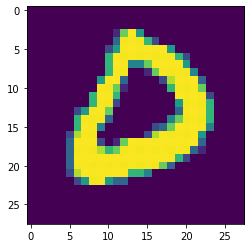

In [7]:
for i, data in enumerate(trainloader):
	if i == 10:
		print(data[0][0].shape)
		imshow(data[0][0].reshape(28,28).numpy())

In [8]:
class G(nn.Module):
	def __init__(self):
		super(G, self).__init__()
	
		self.lin = nn.Sequential(
			nn.Linear(400, 3136),
			nn.BatchNorm1d(3136),
			nn.ELU()
		)

		self.deconvs = nn.Sequential(
			nn.ConvTranspose2d(64, 128, 10),
			nn.BatchNorm2d(128),
			nn.ELU(),

			nn.ConvTranspose2d(128, 1, 13),
			nn.Tanh()
		)

	def forward(self, x):
		x = self.lin(x)
		x = x.reshape(BATCH, 64, 7, 7)
		x = self.deconvs(x)

		return x

noise shape: torch.Size([256, 400])
out shape: torch.Size([256, 1, 28, 28])
out 0 shape: torch.Size([1, 28, 28])


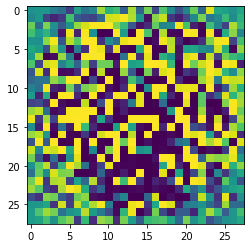

In [9]:
t_generator = G().to(DEVICE)

t_noise = torch.randn(BATCH, 400).to(DEVICE)
print('noise shape:', t_noise.shape)

t_out = t_generator(t_noise)

print('out shape:', t_out.shape)
print('out 0 shape:', t_out[0].shape)

imshow(t_out[0].reshape(t_out.shape[2], t_out.shape[3]).cpu().detach())

In [10]:
class D(nn.Module):
	def __init__(self):
		super(D, self).__init__()

		self.convs = nn.Sequential(
			nn.Conv2d(1, 64, 5),
			nn.BatchNorm2d(64),
			nn.ELU(),

			nn.Conv2d(64, 128, 5),
			nn.BatchNorm2d(128),
			nn.ELU(),
		)

		self.classifier = nn.Sequential(nn.Linear(128 * 20 * 20, 1), nn.Sigmoid())

	def forward(self, x):
		x = self.convs(x)
		x = x.reshape(x.shape[0], -1)
		x = self.classifier(x)

		return x

In [11]:
generator = G().to(DEVICE)
discriminator = D().to(DEVICE)

In [12]:
bce = nn.BCELoss().to(DEVICE)

g_optim = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999)) # 3e-4
d_optim = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999)) # 1e-5

EPOCHS = 2

d_losses = []
g_losses = []

In [13]:
def get_noise():
  n = torch.randn(BATCH, 400).to(DEVICE)
  return n

In [14]:
def test_render(g):
  n1 = get_noise()
  out = g(n1)
  return out[0].reshape(out.shape[2], out.shape[3]).cpu().detach()

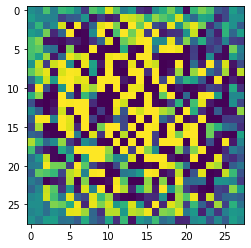

In [15]:
imshow(test_render(generator))

0it [00:00, ?it/s]

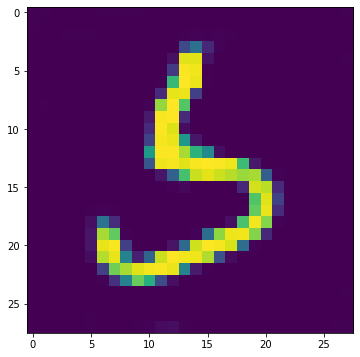

3it [00:00,  6.40it/s]


 EPOCH 0 iter 0 
 g_loss 9.213976860046387 
 d_loss 0.011254364624619484 



49it [00:03, 16.64it/s]

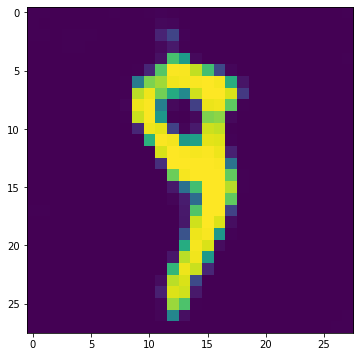

53it [00:03, 13.45it/s]


 EPOCH 0 iter 50 
 g_loss 9.166913032531738 
 d_loss 0.004217096604406834 



99it [00:06, 16.62it/s]

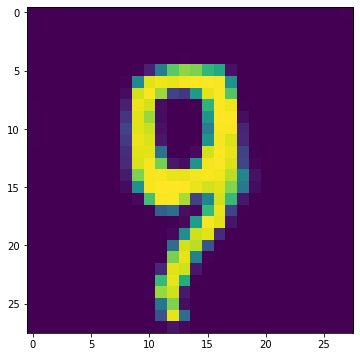

103it [00:06, 13.50it/s]


 EPOCH 0 iter 100 
 g_loss 5.292329788208008 
 d_loss 0.5513646602630615 



149it [00:09, 16.75it/s]

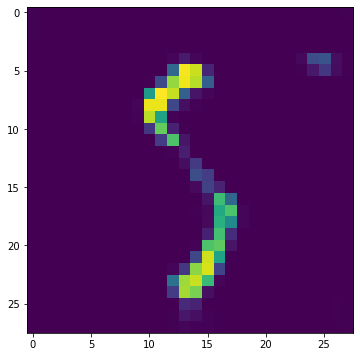

153it [00:09, 13.56it/s]


 EPOCH 0 iter 150 
 g_loss 7.121742248535156 
 d_loss 0.11422712355852127 



199it [00:12, 16.75it/s]

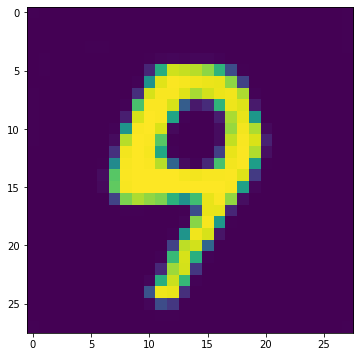

203it [00:13, 13.60it/s]


 EPOCH 0 iter 200 
 g_loss 7.28077507019043 
 d_loss 0.11485868692398071 



235it [00:15, 15.56it/s]
0it [00:00, ?it/s]

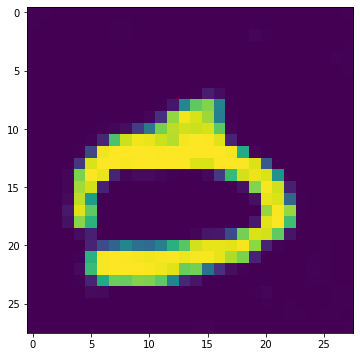

3it [00:00,  7.11it/s]


 EPOCH 1 iter 235 
 g_loss 7.517743110656738 
 d_loss 0.03326310217380524 



49it [00:03, 16.56it/s]

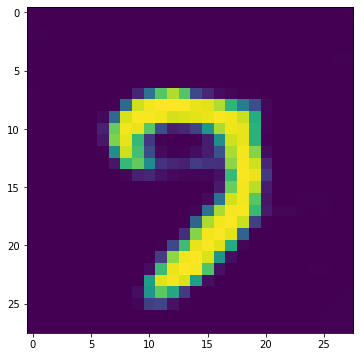

53it [00:03, 13.41it/s]


 EPOCH 1 iter 285 
 g_loss 7.049924850463867 
 d_loss 0.28154078125953674 



99it [00:06, 16.62it/s]

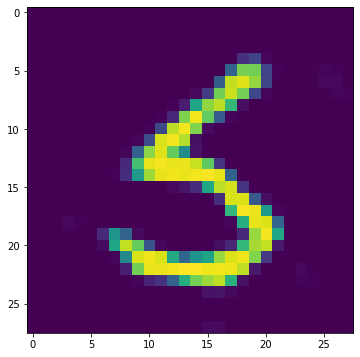

103it [00:06, 13.45it/s]


 EPOCH 1 iter 335 
 g_loss 6.683825969696045 
 d_loss 0.13409678637981415 



149it [00:09, 15.84it/s]

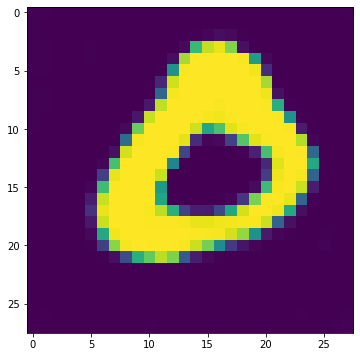

153it [00:10, 13.18it/s]


 EPOCH 1 iter 385 
 g_loss 7.124101161956787 
 d_loss 0.1513240486383438 



199it [00:12, 16.64it/s]

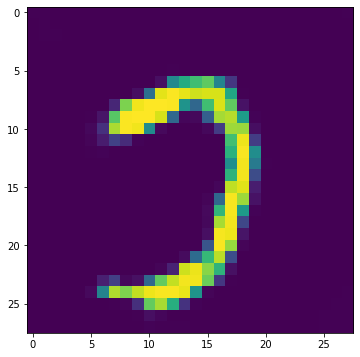

203it [00:13, 13.42it/s]


 EPOCH 1 iter 435 
 g_loss 7.704502105712891 
 d_loss 0.01611400954425335 



235it [00:15, 15.37it/s]
100%|██████████| 2/2 [00:31<00:00, 15.75s/it]


In [105]:
# todo: try training on each number individually

figsize(6, 6)

ns1 = 12
ns2 = 12

j = 0
for epoch in trange(EPOCHS):
	for i, data in tqdm(enumerate(trainloader)):

		images = data[0].to(DEVICE)

		# train discriminator
		discriminator.zero_grad()

		d_out_real = discriminator(images)
		d_loss_real = bce(d_out_real, torch.ones(d_out_real.shape[0], 1).to(DEVICE))
		d_loss_real.backward()
		d_optim.step()

		discriminator.zero_grad()

		noise1 = get_noise()
		g_out_fake = generator(noise1).detach()
		d_out_fake = discriminator(g_out_fake)
		d_loss_fake = bce(d_out_fake, torch.zeros(d_out_fake.shape[0], 1).to(DEVICE))
		d_loss_fake.backward()
		d_optim.step()

		d_loss_avg = (d_loss_real + d_loss_fake) / 2
		d_losses.append(d_loss_avg.item())
		
		# train generator
		generator.zero_grad()

		noise2 = get_noise()
		g_out1 = generator(noise2)
		d_out1 = discriminator(g_out1)
		t_loss1 = bce(d_out1, torch.ones(d_out1.shape[0], 1).to(DEVICE))

		t_loss1.backward()
		g_optim.step()

		g_losses.append(t_loss1.item())

		if i % 50 == 0:
			imshow(test_render(generator))
			show()
			print(
					'\n',
					'EPOCH', epoch, 'iter', j,
					'\n',
					'g_loss', g_losses[len(g_losses) - 1],
					'\n',
					'd_loss', d_losses[len(d_losses) - 1],
					'\n',
			)

		j += 1

In [27]:
print(g_losses[0])
print(d_losses[1])
print(g_losses[len(g_losses) - 1])
print(d_losses[len(d_losses) - 1])

3.9488978385925293
6.488022804260254
7.20908260345459
0.07480588555335999


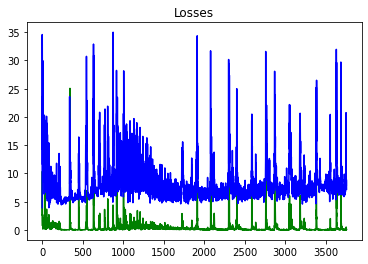

In [28]:
plt.plot(range(len(d_losses)), d_losses, 'g', label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, 'b', label='Generator Loss')
plt.title('Losses')
plt.show()

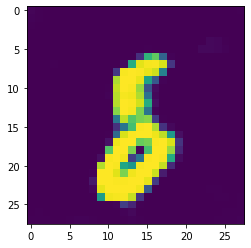

In [47]:
# n1 = torch.randn(BATCH, 1, ns1, ns2).to(DEVICE)
n1 = get_noise()
out = generator(n1)
imshow(out[0].reshape(28, 28).cpu().detach())

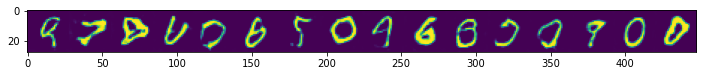

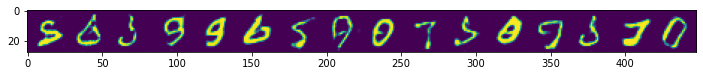

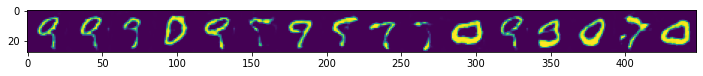

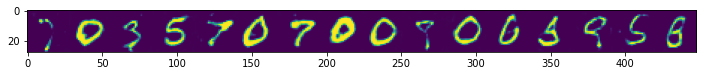

In [104]:
for _ in range(4):
  images = torch.tensor([])
  for i in range(16):
    n1 = get_noise()
    out = generator(n1)
    gen = out[0].reshape(28, 28).cpu().detach()
    images = torch.cat((images, gen.T))
  
  figsize(12,12)
  imshow(images.T)
  show()